In [4]:
# 라이브러리 및 모듈 import
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import pandas as pd
import cv2
import os
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from tqdm.notebook import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as patches
from collections import Counter

sns.set_style("darkgrid")

## Data path Setting

In [5]:
annotation = '/opt/ml/detection/dataset/train.json'
data_dir = '/opt/ml/detection/dataset'

## DataFrame 생성

In [6]:
with open(annotation) as json_file:
    anns = json.load(json_file)

print(anns.keys())
# print(json.dumps(anns['info'], indent=4))
# print(json.dumps(anns['licenses'], indent=4))
# print(json.dumps(anns['images'], indent=4))
# print(json.dumps(anns['categories'], indent=4))
# print(json.dumps(anns['annotations'][0], indent=4))
print()

label_name = [ann_dict['name'] for ann_dict in anns['categories']]
print(f"labels : {label_name}")

df = pd.json_normalize(anns['annotations'])
df[["X","Y","W","H"]] = list(df.bbox)
df.drop(columns='bbox', inplace=True)
# df['WH_ratio'] = df['W']/df['H']
# df['HW_ratio'] = df['H']/df['W']
df['sqrt_area'] = np.sqrt(df['area'])
df['category_name'] = df['category_id'].apply(lambda x: label_name[x])
df = df[['id', 'image_id', 'category_id', 'category_name', 'area', 'sqrt_area', 'X', 'Y', 'W', 'H', 'iscrowd']]
if len(df['iscrowd'].unique()) == 1:
    df.drop(columns='iscrowd', inplace=True)

print(f"num of image : {len(df['image_id'].unique())}")
df.sample(10)

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

labels : ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
num of image : 4883


,id,image_id,category_id,category_name,area,sqrt_area,X,Y,W,H
20234,20234,4260,5,Plastic,1249.68,35.350813,0.0,629.8,50.8,24.6
13692,13692,2918,1,Paper,1997.96,44.698546,888.6,644.4,25.1,79.6
18767,18767,3953,1,Paper,11209.55,105.875162,158.5,337.0,97.9,114.5
16370,16370,3443,4,Glass,138600.00,372.290209,577.3,131.4,210.0,660.0
18301,18301,3850,5,Plastic,49382.15,222.220949,32.5,173.2,264.5,186.7
652,652,132,0,General trash,1624.50,40.305087,408.7,497.8,45.0,36.1
15215,15215,3209,1,Paper,133021.00,364.720441,350.2,158.8,434.0,306.5
3457,3457,738,5,Plastic,377579.06,614.474621,168.0,292.3,793.4,475.9
2526,2526,537,0,General trash,863.95,29.393026,957.6,64.8,46.7,18.5
15432,15432,3248,0,General trash,250050.00,500.049998,99.1,153.2,500.0,500.1


## DF Describe

In [7]:
df.describe().round(2)

,id,image_id,category_id,area,sqrt_area,X,Y,W,H
count,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00
mean,11571.50,2439.38,3.41,92863.96,244.44,386.20,382.23,257.50,252.24
std,6681.24,1410.66,2.83,135979.15,181.97,244.49,217.28,204.58,200.14
min,0.00,0.00,0.00,0.56,0.75,0.00,0.00,0.70,0.80
25%,5785.75,1206.00,1.00,9997.67,99.99,200.10,226.98,99.75,93.50
50%,11571.50,2453.50,3.00,38938.47,197.33,362.70,370.50,200.90,196.10
75%,17357.25,3678.00,7.00,119122.48,345.14,553.32,524.90,357.65,359.82
max,23143.00,4882.00,9.00,1048371.21,1023.90,1015.40,1011.50,1023.90,1023.90


## Class 분포
- 전체 오브젝트들의 class 분포를 살펴봅니다.

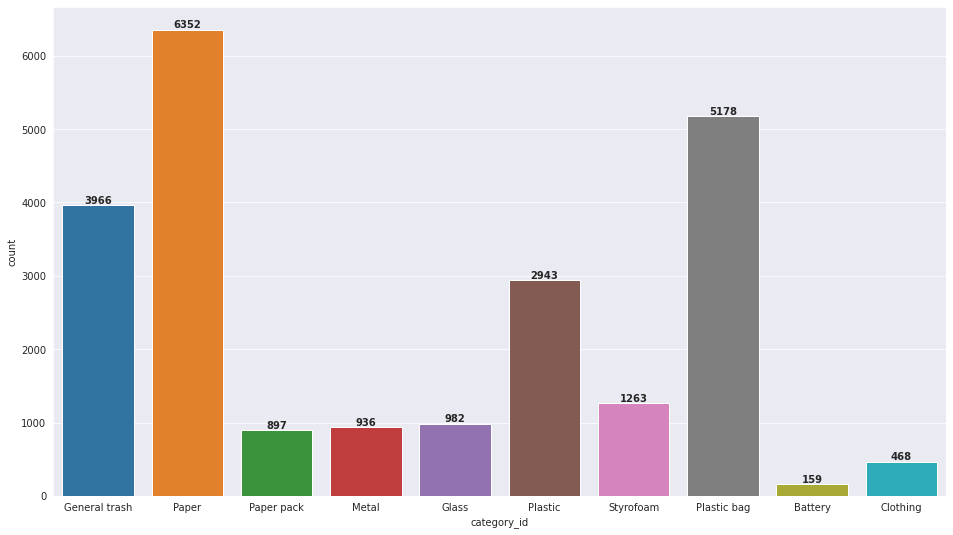

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.countplot(x='category_id', data=df, ax=ax)
ax.set(xticks=range(len(label_name)), xticklabels=label_name)

for idx, val in df['category_id'].value_counts().sort_index().iteritems():
    ax.text(x=idx, y=val, s=val,
            va='bottom', ha='center',
            fontsize=10, fontweight='semibold'
           )

plt.show()

## Image당 지표 확인
- 전체 데이터에서 이미지당 포함된 class의 갯수와 object의 갯수를 추출합니다.

In [9]:
img_by = df[['image_id', 'category_id']].groupby(['image_id']).agg([pd.Series.count, pd.Series.nunique])
img_by.columns = list(map(lambda x: 'cat_' + x[1],img_by.columns))
img_by.sample(10)

,cat_count,cat_nunique
image_id,,
1582,2,2
2717,1,1
3934,1,1
3957,2,1
1941,1,1
1310,1,1
1217,7,4
4843,2,1
2549,4,3


In [10]:
img_by.describe()

,cat_count,cat_nunique
count,4883.000000,4883.000000
mean,4.739709,1.934876
std,6.355155,1.252878
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,6.000000,3.000000
max,71.000000,7.000000


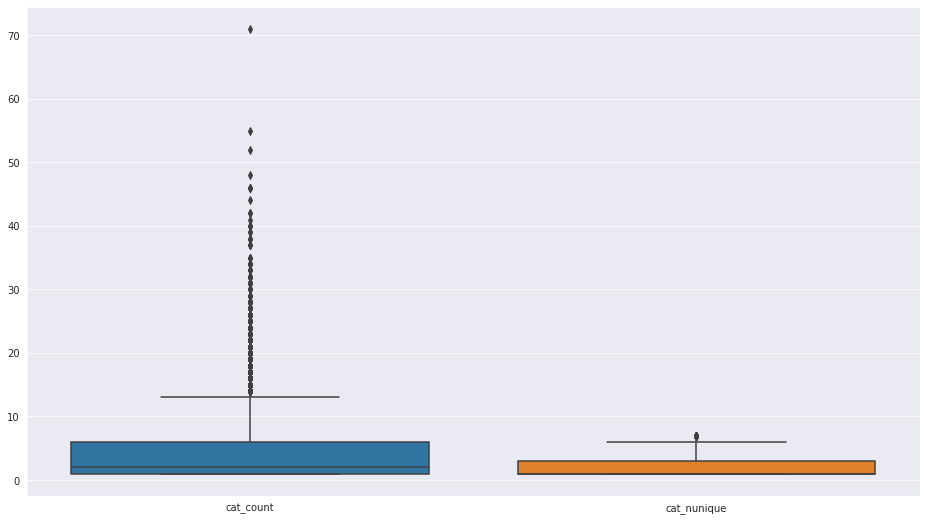

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
# sns.kdeplot(x='W', y='H', hue='category_name', data=df, ax=ax)
sns.boxplot(data=img_by, ax=ax)
plt.show()

## Image당 지표 시각화

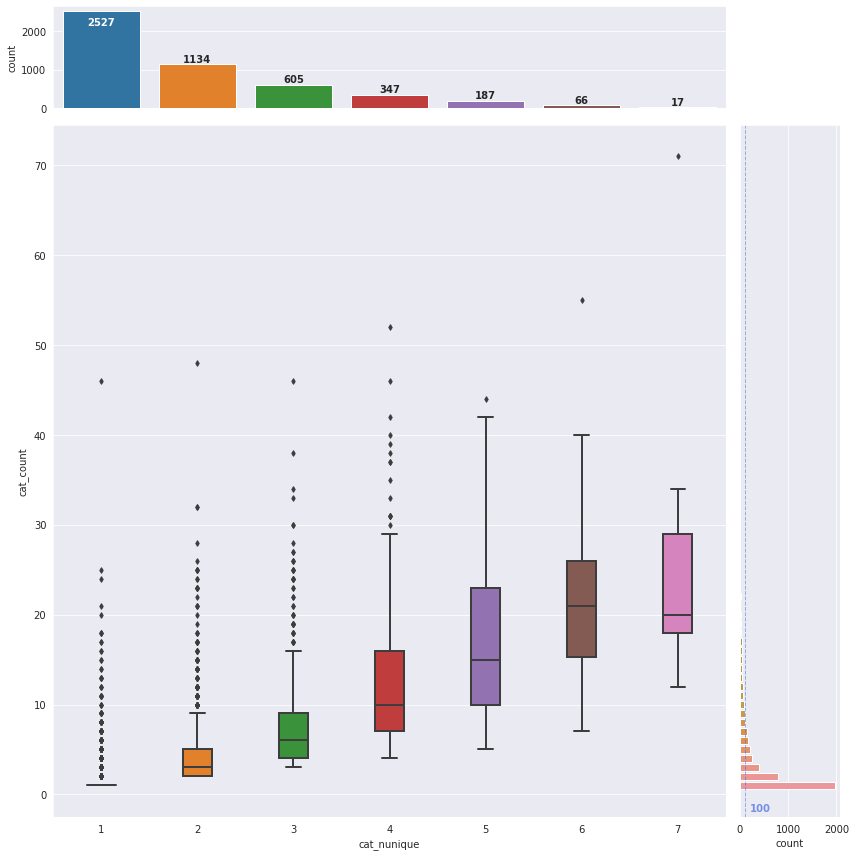

In [12]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(7, 7) # make 3 by 3 grid (row, col)
axes = [None for _ in range(3)]

axes[0] = fig.add_subplot(gs[0, :6])
axes[1] = fig.add_subplot(gs[1:, :6])
axes[2] = fig.add_subplot(gs[1:, 6])

sns.boxplot(x='cat_nunique', y='cat_count', data=img_by, width=0.3, linewidth=2, fliersize=4, ax=axes[1])
# sns.boxenplot(x='cat_nunique', y='cat_count', data=img_by, width=0.3, linewidth=2, ax=axes[1])
ylim = axes[1].get_ylim()

sns.countplot(x='cat_nunique', data=img_by, ax=axes[0])
# sns.histplot(x='cat_nunique', data=img_by, bins=6, ax=axes[0])
# axes[0].spines[['top', 'bottom', 'right']].set_visible(False)
axes[0].xaxis.set_visible(False)
# axes[0].grid()
for idx, val in img_by['cat_nunique'].value_counts().iteritems():
    if val > 2000:
        axes[0].text(x=idx-1, y=val-150, s=val,
                va='top', ha='center',
                fontsize=10, fontweight='semibold', color='w'
            )
    else:
        axes[0].text(x=idx-1, y=val, s=val,
                va='bottom', ha='center',
                fontsize=10, fontweight='semibold'
            )

sns.countplot(y='cat_count', data=img_by, order=list(range(img_by['cat_count'].max()+1)), ax=axes[2])
axes[2].set_ylim(ylim)
# sns.histplot(y='cat_count', data=img_by, bins=71, ax=axes[2])
# axes[2].spines[['top', 'right', 'left']].set_visible(False)
axes[2].yaxis.set_visible(False)
# axes[2].grid()
axes[2].axvline(x=100, color='royalblue', linestyle='--', linewidth=1, alpha=0.5)
axes[2].text(x=200, y=-1, s='100', color='royalblue',
            va='top', ha='left',
            fontsize=10, fontweight='semibold', alpha=0.7
           )

plt.tight_layout()
plt.show()

## Image 단위 지표 요약
- 대부분의 이미지당 오브젝트 5개 이하, 클래스종류 2개이하를 포함한다.


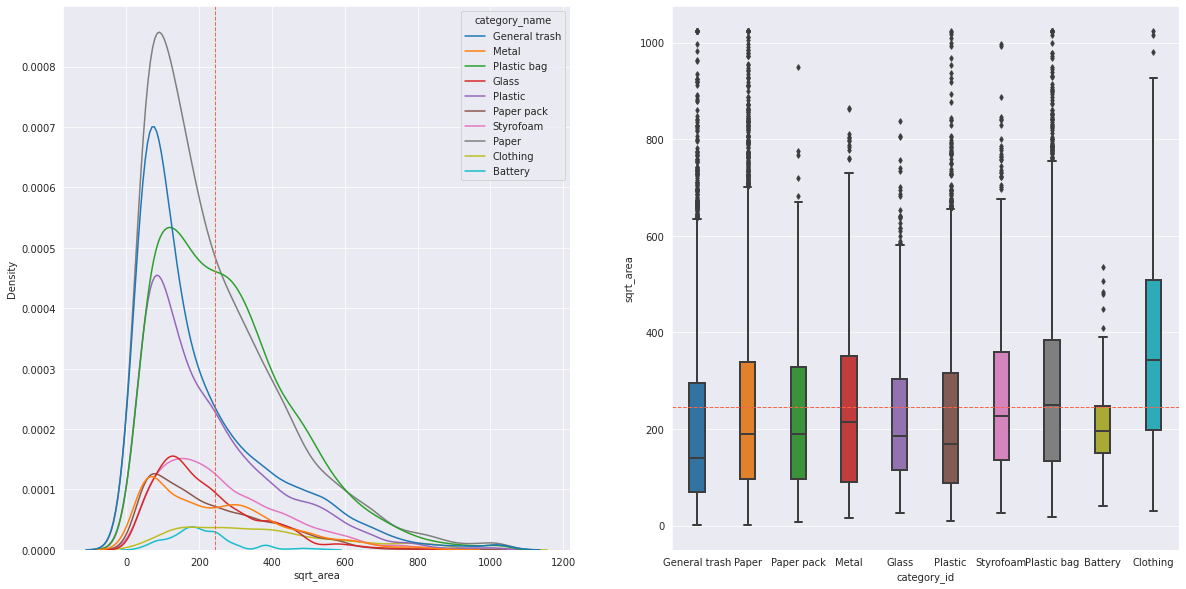

In [13]:
fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.kdeplot(x='sqrt_area', hue='category_name', data=df, bw_method=0.2, ax=axes[0])
axes[0].axvline(x=df['sqrt_area'].mean(), color='tomato', linestyle='--', linewidth=1)

# sns.histplot(x='sqrt_area', hue='category_id' ,data=df, ax=axes[0])
sns.boxplot(x='category_id', y='sqrt_area', data=df, width=0.3, linewidth=2, fliersize=4, ax=axes[1])
axes[1].set(xticks=range(len(label_name)), xticklabels=label_name)
axes[1].axhline(y=df['sqrt_area'].mean(), color='tomato', linestyle='--', linewidth=1)
plt.show()

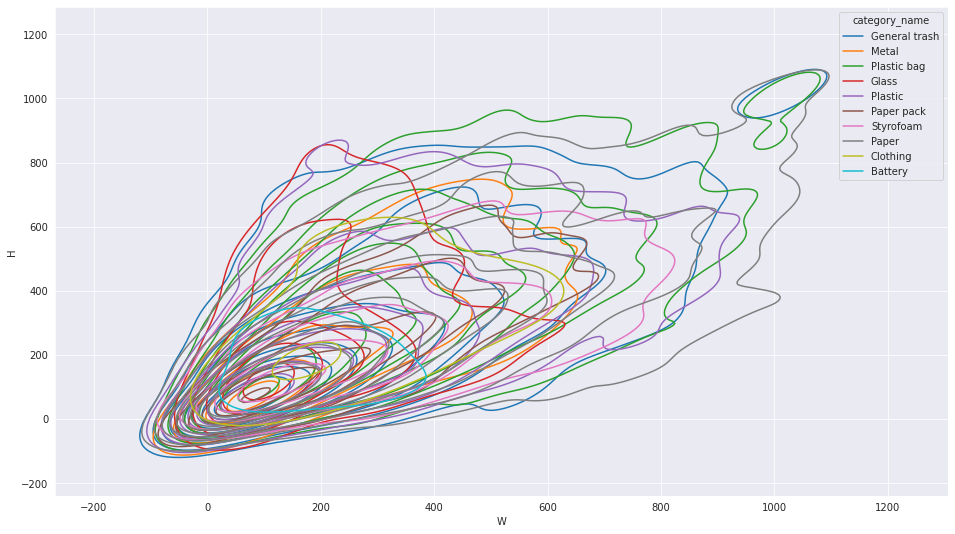

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.kdeplot(x='W', y='H', hue='category_name', data=df, ax=ax)
plt.show()

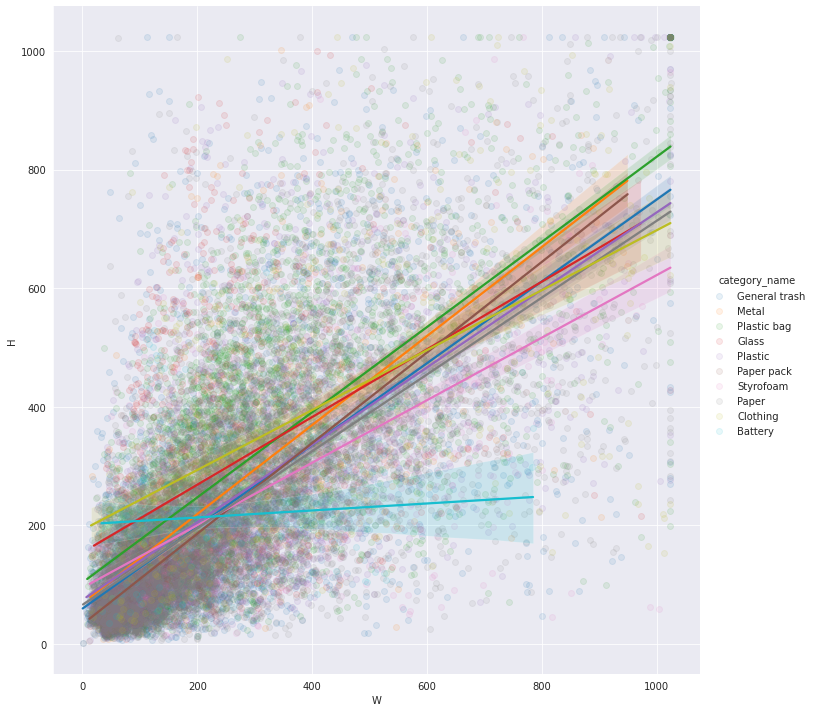

In [15]:
# fig, ax = plt.subplots(figsize=(16, 9))
sns.lmplot(x='W', y='H', hue='category_name', data=df, scatter_kws={'alpha':0.1}, height=10)
plt.show()

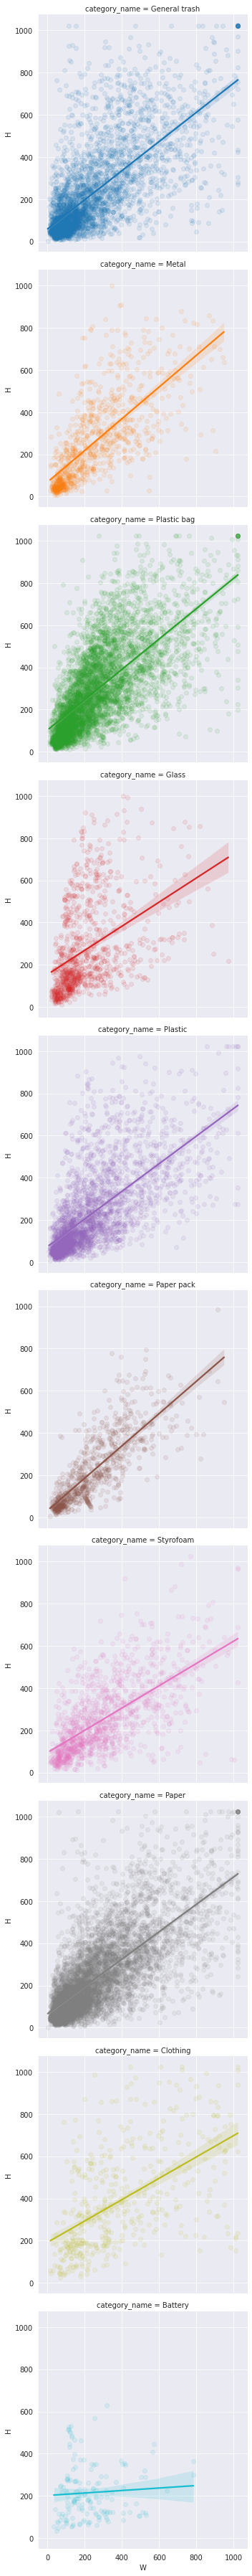

In [16]:
# fig, ax = plt.subplots(figsize=(16, 9))
sns.lmplot(x='W', y='H', hue='category_name', data=df, row='category_name', scatter_kws={'alpha':0.1})
plt.show()

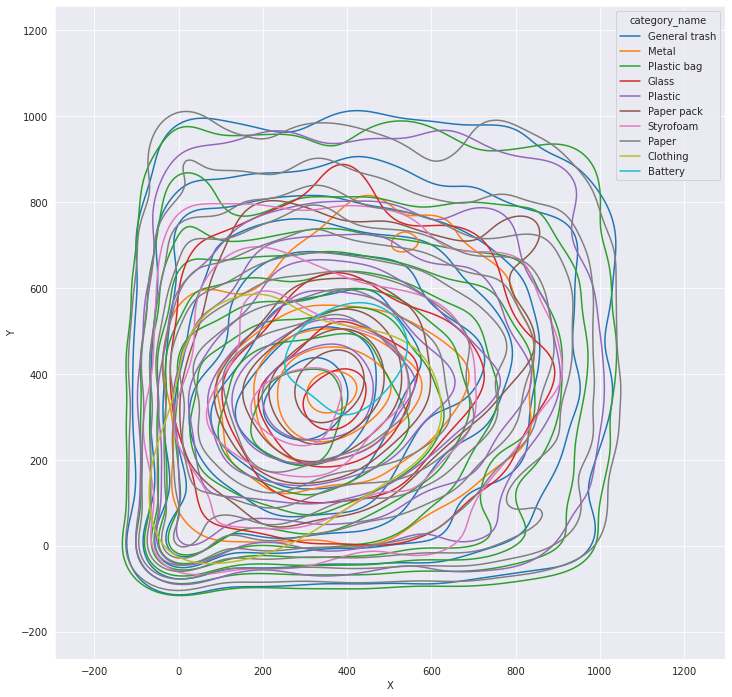

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.kdeplot(x='X', y='Y', hue='category_name', data=df, ax=ax)
plt.show()

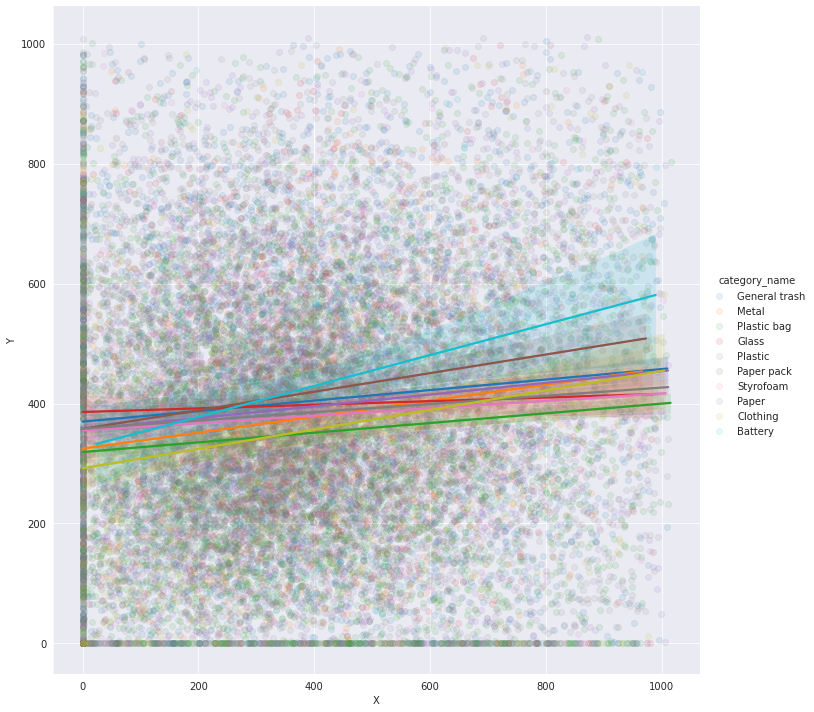

In [18]:
# fig, ax = plt.subplots(figsize=(16, 9))
sns.lmplot(x='X', y='Y', hue='category_name', data=df, scatter_kws={'alpha':0.1}, height=10)
plt.show()

In [19]:
df[df['X']<10]

,id,image_id,category_id,category_name,area,sqrt_area,X,Y,W,H
1,1,1,3,Metal,10402.56,101.992941,0.0,407.4,57.6,180.6
2,2,1,7,Plastic bag,26259.36,162.047400,0.0,455.6,144.6,181.6
5,5,1,5,Plastic,188324.40,433.963593,3.7,448.5,778.2,242.0
18,18,5,7,Plastic bag,41210.00,203.002463,0.0,148.3,317.0,130.0
33,33,5,7,Plastic bag,143643.78,379.003668,0.0,129.3,333.9,430.2
...,...,...,...,...,...,...,...,...,...,...
23061,23061,4858,1,Paper,198029.58,445.005146,0.0,376.2,488.6,405.3
23069,23069,4858,1,Paper,9621.20,98.087716,0.0,234.7,67.0,143.6
23070,23070,4858,1,Paper,12243.20,110.648995,0.0,394.2,64.0,191.3
23100,23100,4871,1,Paper,10095.46,100.476166,0.0,235.3,117.8,85.7


In [20]:
df[df['Y']<10]

,id,image_id,category_id,category_name,area,sqrt_area,X,Y,W,H
11,11,3,6,Styrofoam,80710.56,284.096040,773.3,3.0,188.4,428.4
29,29,5,7,Plastic bag,7963.68,89.239453,948.5,0.0,75.2,105.9
30,30,5,7,Plastic bag,229774.60,479.348099,55.5,0.0,961.4,239.0
43,43,8,6,Styrofoam,251634.04,501.631379,51.8,0.0,635.6,395.9
45,45,8,7,Plastic bag,87462.75,295.741018,170.3,0.0,415.5,210.5
...,...,...,...,...,...,...,...,...,...,...
22906,22906,4826,7,Plastic bag,325337.76,570.383871,120.6,0.0,524.4,620.4
22925,22925,4835,5,Plastic,183591.10,428.475320,610.0,0.0,248.6,738.5
22947,22947,4838,0,General trash,289284.60,537.851838,324.1,0.0,699.6,413.5
23048,23048,4857,0,General trash,1048064.06,1023.749999,0.0,0.0,1023.8,1023.7


In [21]:
df[df['W']<10]

,id,image_id,category_id,category_name,area,sqrt_area,X,Y,W,H
1524,1524,298,7,Plastic bag,441.15,21.003571,1015.4,802.4,8.5,51.9
4367,4367,912,1,Paper,522.72,22.863071,410.9,595.0,9.9,52.8
5159,5159,1063,0,General trash,0.56,0.748331,647.8,460.2,0.7,0.8
6539,6539,1377,1,Paper,3.12,1.766352,719.8,604.7,1.3,2.4
6790,6790,1426,0,General trash,478.24,21.868699,358.6,190.2,9.8,48.8
12473,12473,2630,7,Plastic bag,301.71,17.369801,570.2,822.5,8.9,33.9
12515,12515,2639,0,General trash,461.02,21.471376,790.3,459.5,8.9,51.8
13598,13598,2902,5,Plastic,365.65,19.121977,419.0,51.1,7.1,51.5
14991,14991,3148,0,General trash,573.40,23.945772,14.0,880.8,9.4,61.0
17440,17440,3697,7,Plastic bag,949.63,30.816067,485.3,335.6,9.7,97.9


In [ ]:
df[df['H']<10]

In [ ]:
df.sort_values(['H','W']).tail(25)

In [ ]:
len(df[(df['H']>1000) & (df['W']>1000)])

In [ ]:
a = df[['image_id', 'category_id']].groupby(['image_id']).agg([pd.Series.count, pd.Series.nunique])

In [ ]:
a.columns

In [ ]:
a.sort_values(('category_id',   'count')).tail(16).index.tolist()

In [ ]:
df[(df['X'] > 1000) | (df['Y'] > 1000)]['image_id'].values.tolist()